In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
def train_model(model, trainloader, testloader, optimizer, criterion, epochs=10):
    model.train()
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'epochs': []
    }
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        
        model.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        
        test_accuracy = 100. * correct_test / total_test
        

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(train_accuracy)
        history['test_acc'].append(test_accuracy)
        history['epochs'].append(epoch + 1)
        

        print(f"Epoch {epoch+1}")
        print(f"Loss: {epoch_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        print('-' * 30)
    
    return history

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['epochs'], history['train_loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epochs'], history['train_acc'], label='Training Accuracy')
    plt.plot(history['epochs'], history['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy Over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.classifier(x)
        return x

In [7]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

In [8]:
history = train_model(model, trainloader, testloader, optimizer, criterion)

Epoch 1
Loss: 1.8950
Training Accuracy: 29.56%
Test Accuracy: 47.91%
------------------------------
Epoch 2
Loss: 1.2681
Training Accuracy: 54.14%
Test Accuracy: 61.38%
------------------------------
Epoch 3
Loss: 0.9305
Training Accuracy: 67.16%
Test Accuracy: 70.21%
------------------------------
Epoch 4
Loss: 0.7160
Training Accuracy: 74.95%
Test Accuracy: 73.16%
------------------------------
Epoch 5
Loss: 0.5591
Training Accuracy: 80.40%
Test Accuracy: 76.33%
------------------------------
Epoch 6
Loss: 0.4266
Training Accuracy: 84.98%
Test Accuracy: 76.92%
------------------------------
Epoch 7
Loss: 0.3049
Training Accuracy: 89.33%
Test Accuracy: 77.83%
------------------------------
Epoch 8
Loss: 0.2102
Training Accuracy: 92.47%
Test Accuracy: 77.43%
------------------------------
Epoch 9
Loss: 0.1502
Training Accuracy: 94.63%
Test Accuracy: 77.23%
------------------------------
Epoch 10
Loss: 0.1113
Training Accuracy: 96.11%
Test Accuracy: 75.20%
------------------------------

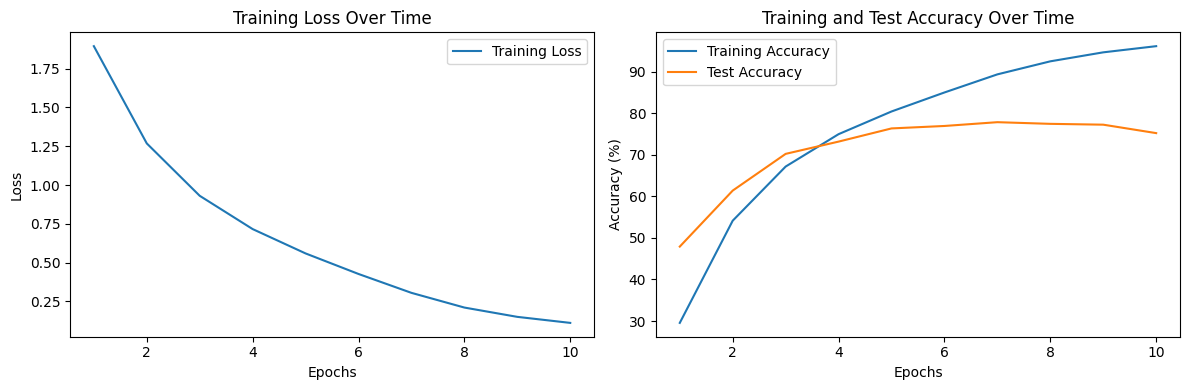

In [9]:
plot_training_history(history)

In [10]:
def evaluate_model(model, testloader, num_classes=10):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
 
    correct = (all_predictions == all_labels).sum()
    total = len(all_labels)
    accuracy = 100 * correct / total
    

    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, 
        all_predictions, 
        average=None, 
        zero_division=0 
    )
    

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    

    print(f"Overall Accuracy: {accuracy:.2f}%")
    print("\nPer-class metrics:")
    print(f"{'Class':<10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
    print("-" * 55)
    
    for i in range(num_classes):
        print(f"{classes[i]:<10} {precision[i]:>10.4f} {recall[i]:>10.4f} {f1[i]:>10.4f} {support[i]:>10}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'confusion_matrix': conf_matrix
    }

In [11]:
evaluate_model(model, testloader)

Overall Accuracy: 75.20%

Per-class metrics:
Class       Precision     Recall         F1    Support
-------------------------------------------------------
plane          0.7572     0.8420     0.7973       1000
car            0.9227     0.8120     0.8638       1000
bird           0.8034     0.6130     0.6954       1000
cat            0.4891     0.6960     0.5745       1000
deer           0.8370     0.6110     0.7064       1000
dog            0.6364     0.7070     0.6698       1000
frog           0.8919     0.7180     0.7956       1000
horse          0.8323     0.8090     0.8205       1000
ship           0.9093     0.7820     0.8409       1000
truck          0.6920     0.9300     0.7935       1000


{'accuracy': 75.2,
 'precision': array([0.75719424, 0.92272727, 0.8034076 , 0.48910752, 0.8369863 ,
        0.63636364, 0.89192547, 0.83230453, 0.90930233, 0.69196429]),
 'recall': array([0.842, 0.812, 0.613, 0.696, 0.611, 0.707, 0.718, 0.809, 0.782,
        0.93 ]),
 'f1': array([0.79734848, 0.86382979, 0.69540556, 0.57449443, 0.70635838,
        0.66982473, 0.79556787, 0.82048682, 0.84086022, 0.79351536]),
 'support': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]),
 'confusion_matrix': array([[842,   9,  14,  23,   4,  11,   5,   8,  23,  61],
        [ 12, 812,   2,  10,   2,   4,   1,   0,  11, 146],
        [ 76,   4, 613, 108,  42,  68,  30,  22,   9,  28],
        [ 23,   1,  28, 696,  23, 146,  18,  23,   9,  33],
        [ 28,   5,  39, 134, 611,  69,  26,  71,   6,  11],
        [  7,   1,  17, 207,   7, 707,   2,  28,   1,  23],
        [  9,   5,  32, 141,  23,  40, 718,   5,   9,  18],
        [ 20,   4,  10,  63,  16,  52,   0, 809,   3,  23],
       